# Lennea start

Willkommen!

So, erste Aufgaben fuer dich sind dich mit der Technik und die Mathematik vertraut zu machen. 

## Wissenschaft

1. Power laws, Pareto distributiopns and Zipf's law, Newman
2. Power-Law Scaling in the Internal Variability of Cumulus Cloud Size Distributions due to Subsampling and Spatial Organization, Neggers Griewank Heus
3. Investigating the Diurnal Evolution of the Cloud Size Distribution of Continental Cumulus Convection Using Multiday LES, van Laar Schemann Neggers

## Technik
Alles gut googlebar, oder rumfragen, wird viel hier am Institut verwendet
1. Python3
2. Jupyter notebooks, interactive python benutzen
3. Git, zum code teilen.
4. Python matplotlib, plotten. 

## Zum warmwerden

* Newman section 1 und 2 gut durchlesen
* jupyterlab mit python3 installieren (benutze pip dafuer), neues notebook anlegen. Lerne Markdown zu verwenden, Zellen anzulegen, code ausfuehren, kernel neustarten, usw
* github account aufmachen, test repository machen
* lege nen Ornder bei dir an, mache es privat (tipp: chmod)
* Finde raus wieviel speicherplatz du aif deinem Rechner hast
* Code beispiele unten anschauen, versuche alle commandos zu verstehen
* Schreibe fuer die funktion linear_binner eine Beschreibung wie fuer log_binner.
* Mache es so, dass linear_binner ein 'nan' rausgibt wenn weniger als N_min in dem bin sind.
* Mache eine alternative funktion log_binner_minmax. Hier sollen die bins generiert werden aus einem minimal Wert, ein maximal Wert, und eine Anzahl bins die der funktion uebergeben werden (z.B. log_binner_minmax(var,bin_min,bin_max,bin_n))
* Generiere dir ein paar Daten die eine logaritmische Verteilung haben. Mache daraus die gleichen plots wie Newman Figure 3
* Bestimme aus deinen Daten den Exponenten der Verteilungsfunktion, mit und ohne bins. Zeige wie die Binweite den Wert des Exponenten beeinflusst.  

# Beispiel code

In [658]:
import numpy as np
import matplotlib.pyplot as plt
import powerlaw
from scipy import stats

In [20]:
def log_binner(var,bin_min=25,step_ratio=2,N_min=0):
    """
    Bins a vector of values into logarithmic bins
    
    Bins are defined by a minimal width, and a step ratio. 
    
    Parameters: 
        var: input vector
        bin_min: Value of the smallest bin
        step_ratio: ratio of bin boundaries, e.g. 1.5, 100 to 150
        N_min: Minimal number of values needed per bin, if less a nan is returned. 
    
    Returns:
        bin_n: number of bins
        bins: vector of bin edges, is bin_n+1 long
        ind: gives for each value of the var array in which bin it is
        CSD: Non normalized distribution of var over the bins. 
    """
    max_val   = max(var)
    min_val   = min(var)
    #bin_min = max(min_val,bin_min)


    log_bin_dist = np.log10(step_ratio)
    max_log = np.log10(max_val/bin_min)

    bins = bin_min*10**(np.arange(0,max_log+log_bin_dist,log_bin_dist))
    bin_n = len(bins)-1
    ind       = np.digitize(var,bins)
    CSD       = np.zeros(bin_n)
    for b in range(bin_n):
        if len(ind[ind==b+1])>N_min:
            CSD[b] = float(np.count_nonzero(ind==b+1))/(bins[b+1]-bins[b])
        else:
            CSD[b] = 'nan'
    return bin_n, bins, ind, CSD 


In [583]:
def linear_binner(var,width,N_min=0):
    """
    Bins a vector of values into bins of the same width
    
    Parameters:
        var: input vector
        width: width of each bin
        N_min: Minimal number of values needed per bin, if less a nan is returned
        
    Returns:
        bin_n: amount of bins, will be an even number
        bins: 1 dimensional array (vector), which is bin_n+1 long
        ind: gives each value of the input vector the index of its respective bin
        CSD: linear distribution scaled by width of the bin
    """
    max_val   = max(var)
    bin_n     = int(np.ceil(max_val/width))
    bins      = np.linspace(0,bin_n*width,bin_n+1)
    ind       = np.digitize(var,bins)
    CSD       = np.zeros(bin_n) #1D array (size of bin_n) filled with zeros
    for b in range(bin_n):
        if len(ind[ind==b+1])>N_min:
            CSD[b] = float(np.count_nonzero(ind==b+1))/width
        else:
            CSD[b] = 'nan'

    return bin_n, bins, ind, CSD 


In [560]:
def log_binner_minmax(var,bin_min,bin_max,bin_n,N_min=0):
    """
    Parameters:
        var: input vector
        bin_min: value of the first bin
        bin_max: value of the last bin
        bin_n: number of bins 
        
    Returns:
        bins: vector of bin edges, is bin_n+1 long
        ind: gives each value of the input vector the index of its respective bin
        CSD: Non normalized distribution of var over the bins. 
    """
    max_val   = max(var)
    min_val   = min(var)
    bin_min   = max(min_val,bin_min)
    bin_max   = min(max_val,bin_max)
    
    
    max_log = np.log10(bin_max/bin_min)
    
    bins = bin_min*np.logspace(0,max_log,num=bin_n+1)
    ind       = np.digitize(var,bins)
    CSD       = np.zeros(bin_n)
    for b in range(bin_n):
        if len(ind[ind==b+1])>N_min:
            CSD[b] = float(np.count_nonzero(ind==b+1))/(bins[b+1]-bins[b])
        else:
            CSD[b] = 'nan'
    return bins, ind, CSD

In [691]:
def create_s(N_samples,alpha,x_min,x_max):
    """
    Creates random samples with a logarithmic distribution
    
    Parameters:
        N_samples: Number of samples to be generated
        alpha: exponent of the power-law
        x_min: smallest value of x
        x_max: highest value of x
    
    Returns:
        s: random samples
    """
    #Random sampling of x applied to the inverse to generate a sample s
    rand_x = np.random.uniform(low=0,high=1,size=(N_samples))
    s = x_min * (1 - rand_x) ** (-1 / (alpha - 1))

    return s


Text(0, 0.5, 'Random samples')

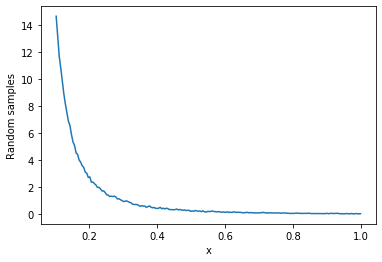

In [214]:
#Plot a from Newman figure 3
y,binEdges=np.histogram(s,bins=200,density=True,range=(x_min,x_max))
bincenters = 0.5*(binEdges[1:]+binEdges[:-1])
plt.plot(bincenters,y)
plt.xlabel('x')
plt.ylabel('Random samples')

-2.506021092786467 -3.028817460679598


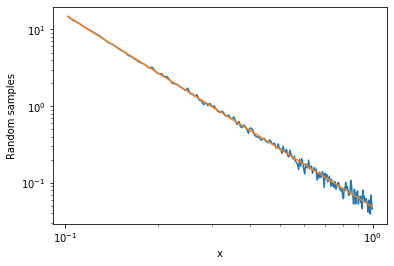

In [665]:
y,binEdges=np.histogram(s,bins=200,density=True,range=(x_min,x_max))
bincenters = 0.5*(binEdges[1:]+binEdges[:-1])
plt.plot(bincenters,y)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('x')
plt.ylabel('Random samples')

m,b = np.polyfit(np.log(bincenters),np.log(y), 1)
f = np.exp(m*np.log(bincenters))*np.exp(b)
plt.plot(bincenters,f)
print(m,b)


(0, 1)

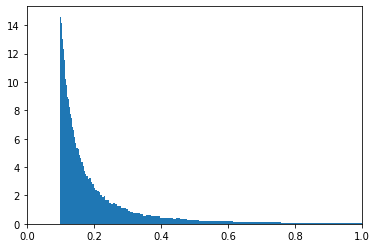

In [233]:
bin_min = 0.1
log_bin_dist = 0.01
max_val = max(s)
max_log = np.log10(max_val/bin_min)
bins = bin_min*10**(np.arange(0,max_log+log_bin_dist,log_bin_dist))
plt.hist(s,bins,density=True);
plt.xlim(left=0,right=1)

Text(0, 0.5, 'Random samples')

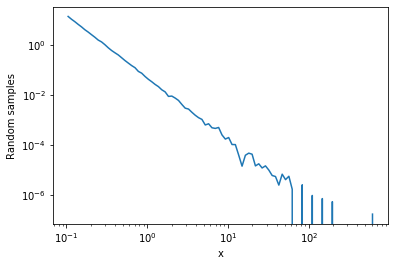

In [251]:
#Plot b from Newman figure 3
y,binEdges=np.histogram(s,bins,density=True,range=(x_min,x_max))
bincenters = 0.5*(binEdges[1:]+binEdges[:-1])
plt.plot(bincenters,y)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('x')
plt.ylabel('Random samples')

-1.5009945805179061 -3.4546220714506433


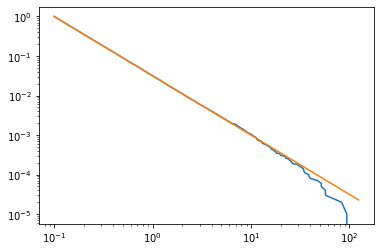

In [617]:
#Philipp versucht auch mal den cumulative distribution zu plotten.
#Newman fig d

s_sortiert = np.sort(s)

s_sortiert = s_sortiert[::-1]
#plt.plot(s_sortiert)
p = np.array(range(N_samples))/float(N_samples)

plt.plot(s_sortiert,p)

m,b = np.polyfit(np.log(s_sortiert[2:]),np.log(p[2:]), 1)
y = np.exp(m*np.log(s_sortiert))*np.exp(b)
plt.plot(s_sortiert,y)
print(m,b)

plt.xscale('log')
plt.yscale('log')

-2.491712516755135 8.506244021707435


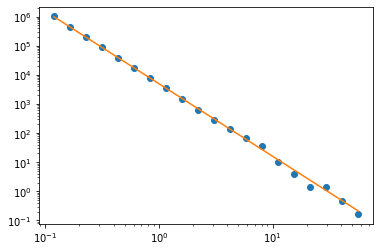

In [562]:
#Newman fig c
bins, ind, CSD = log_binner_minmax(s,np.min(s),np.max(s),20)

#x_bins is same as bincenters
x_bins = bins[:-1]/2.+bins[1:]/2. 

plt.plot(x_bins,CSD, 'o')

plt.xscale('log')
plt.yscale('log')

m,b = np.polyfit(np.log(x_bins[:13]),np.log(CSD[:13]), 1)

y = 10**(m*np.log10(x_bins))*np.exp(b)
plt.plot(x_bins,y)

#stats.linregress(np.log(x_bins[:13]),np.log(CSD[:13]))


print(m,b)

Text(0.5, 1.0, 'Cumulative distribution with an exponent of $\\alpha-1$')

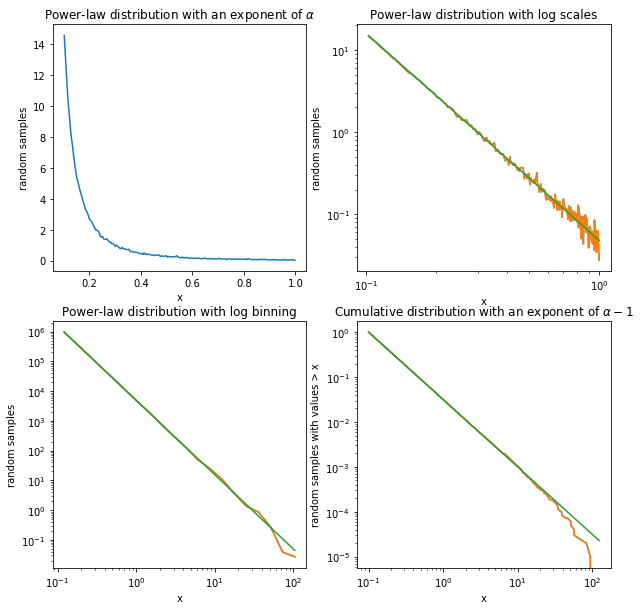

In [637]:
#all four Newman plots in one figure

y,bins_lin = np.histogram(s,bins=200,density=True,range=(x_min,x_max))
x_bins_lin = bins_lin[:-1]/2.+bins_lin[1:]/2. 
m1,b1 = np.polyfit(np.log(x_bins_lin),np.log(y), 1)
f1 = np.exp(m1*np.log(x_bins_lin))*np.exp(b1)
bins_log_mm, ind, CSD = log_binner_minmax(s,np.min(s),np.max(s),20)
x_bins_log_mm = bins_log_mm[:-1]/2.+bins_log_mm[1:]/2.
m2,b2 = np.polyfit(np.log(x_bins_log_mm[:13]),np.log(CSD[:13]), 1)
f2 = 10**(m2*np.log10(x_bins_log_mm))*np.exp(b2)
s_sort = np.sort(s)
s_sort = s_sort[::-1]
p = np.array(range(N_samples))/float(N_samples)
m3,b3 = np.polyfit(np.log(s_sort[2:]),np.log(p[2:]), 1)
f3 = 10**(m3*np.log10(s_sort))*np.exp(b3)

#plots
fig,axes = plt.subplots(2,2,figsize=(10,10))
axes[0,0].plot(x_bins_lin,y)
axes[0,0].set_xlabel('x')
axes[0,0].set_ylabel('random samples')
axes[0,0].set_title(r'Power-law distribution with an exponent of $\alpha$')

axes[0,1].plot(x_bins_lin,y)
axes[0,1].loglog(x_bins_lin,y)
axes[0,1].plot(x_bins_lin,f1)
axes[0,1].set_xlabel('x')
axes[0,1].set_ylabel('random samples')
axes[0,1].set_title('Power-law distribution with log scales')

axes[1,0].plot(x_bins_log_mm,CSD)
axes[1,0].loglog(x_bins_log_mm,CSD)
axes[1,0].plot(x_bins_log_mm,f2)
axes[1,0].set_xlabel('x')
axes[1,0].set_ylabel('random samples')
axes[1,0].set_title('Power-law distribution with log binning')

axes[1,1].plot(s_sort,p)
axes[1,1].loglog(s_sort,p)
axes[1,1].plot(s_sort,f3)
axes[1,1].set_xlabel('x')
axes[1,1].set_ylabel('random samples with values > x')
axes[1,1].set_title(r'Cumulative distribution with an exponent of $\alpha-1$')


In [680]:
def func_newmann3(dist,bin_n,bin_min,bin_max,x_min,x_max):
    """
    written by Lennéa Hayo, 19-08-01
    
    Creates Newmans figure 3 plots of a logarithmic distribution
    
    Parameters:
        dist: distribution of logarithmic data
        bin_n: number of bins
        bin_min: value of the first bin
        bin_max: value of the last bin
        x_min: smallest value of x (used in linear power-law-dist for x-axis)
        x_max: highest value of x (used in linear power-law-dist for x-axis)
        
    Returns:
        fig: plots that resemble Newmans figure 3
        m1: slope linear regression of power-law distribution with log scales
        m2: slope linear regression of power-law distribution with log binning
        m3: slope linear regression of cumulative distribution (alpha-1)

    """
    N_samples = len(dist)
    
    #linear power-law distribution of the data (a,b)
    y,bins_lin = np.histogram(dist,bins=200,density=True,range=(x_min,x_max))
    x_bins_lin = bins_lin[:-1]/2.+bins_lin[1:]/2.
    m1,b1 = np.polyfit(np.log(x_bins_lin),np.log(y), 1)
    f1 = np.exp(m1*np.log(x_bins_lin))*np.exp(b1)
    
    #logarithmic binning of the data (c)
    bins_log_mm, ind, CSD = log_binner_minmax(dist,bin_min,bin_max,20)
    x_bins_log_mm = bins_log_mm[:-1]/2.+bins_log_mm[1:]/2.
    m2,b2 = np.polyfit(np.log(x_bins_log_mm[:13]),np.log(CSD[:13]), 1)
    f2 = 10**(m2*np.log10(x_bins_log_mm))*np.exp(b2)
    
    #cumulative distribution by sorting the data (d)
    dist_sort = np.sort(dist)
    dist_sort = dist_sort[::-1]
    p = np.array(range(N_samples))/float(N_samples)
    m3,b3 = np.polyfit(np.log(dist_sort[2:]),np.log(p[2:]), 1)
    f3 = 10**(m3*np.log10(s_sort))*np.exp(b3)

    fig,axes = plt.subplots(2,2,figsize=(10,10))

    axes[0,0].plot(x_bins_lin,y)
    axes[0,0].set_xlabel('x')
    axes[0,0].set_ylabel('probability density function')
    axes[0,0].set_title(r'Power-law distribution with an exponent of $\alpha$')

    axes[0,1].plot(x_bins_lin,y)
    axes[0,1].loglog(x_bins_lin,y)
    axes[0,1].plot(x_bins_lin,f1)
    axes[0,1].set_xlabel('x')
    axes[0,1].set_ylabel('samples')
    axes[0,1].set_title('Power-law distribution with log scales')

    axes[1,0].plot(x_bins_log_mm,CSD)
    axes[1,0].loglog(x_bins_log_mm,CSD)
    axes[1,0].plot(x_bins_log_mm,f2)
    axes[1,0].set_xlabel('x')
    axes[1,0].set_ylabel('samples')
    axes[1,0].set_title('Power-law distribution with log binning')

    axes[1,1].plot(dist_sort,p)
    axes[1,1].loglog(dist_sort,p)
    axes[1,1].plot(dist_sort,f3)
    axes[1,1].set_xlabel('x')
    axes[1,1].set_ylabel('samples with values > x')
    axes[1,1].set_title(r'Cumulative distribution with an exponent of $\alpha-1$')


    return fig, m1, m2, m3


-2.5231378582550854 -2.4838618625476783 -1.497536187480906


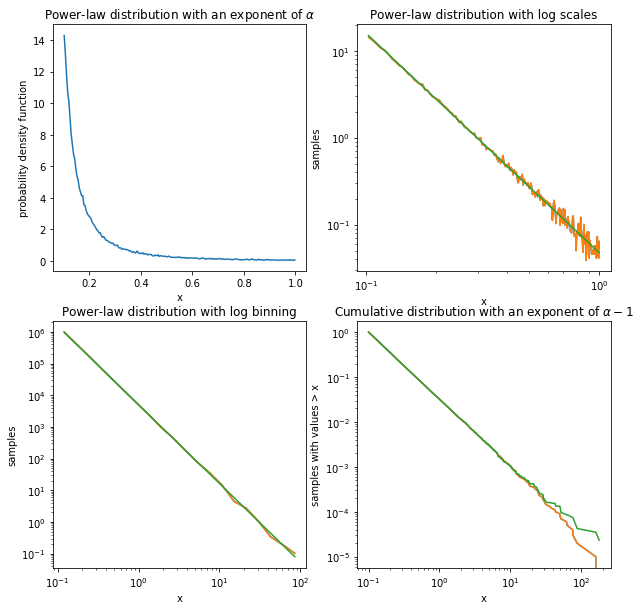

In [681]:
fig, m1, m2, m3 = func_newmann3(s,20,0.1,100,0.1,1)
print(m1,m2,m3)